In [1]:
import tifffile as tiff
import numpy as np
from cellpose import models
from cellpose import plot
from cellpose import io
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import cv2
import pandas as pd
#import umap.umap_ as umap 


In [10]:
sid='p16.tiff' #<<<<<<<< Change file name here 
customized_mask_path = "p16_mask.npy" #<<<<<<<< Change mask file here

In [3]:
import os
import glob

sid = sid
input_file=f"{sid}"
# Load image
image = tiff.imread(input_file)

In [5]:
#cellpose run
model = models.CellposeModel(gpu=False, model_type='TN3')
masks, flows, styles = model.eval(image, diameter=23, channels=[2,3], flow_threshold=0.4)

In [6]:
#count number of cells
num_cells = len(np.unique(masks))-1
print(f"Number of cells detected in this ROI: {num_cells}")

Number of cells detected in this ROI: 1997


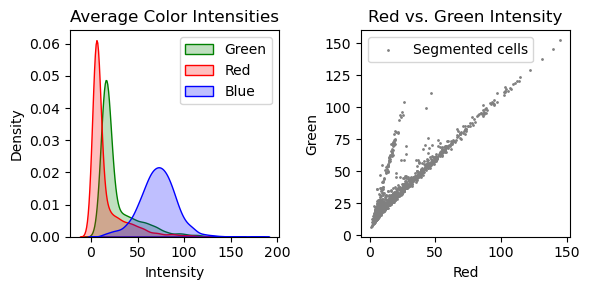

In [8]:
#MAIN post-processing function 
def extract_intensities_and_plot(image, masks):
    # 1. Extract the green, red, and blue channels from the image
    green_channel = image[:, :, 1]
    red_channel = image[:, :, 0]
    blue_channel = image[:, :, 2]
    
    # 2. Initialization
    green_intensities = []
    red_intensities = []
    blue_intensities = []
    Npis = []
    unique_cells = np.unique(masks)
    perimeters = []
    areas = []
    circularities = []
    
    # 3. Iterate through each cell and calculate average intensities
    for cell_id in unique_cells:
        if cell_id == 0:  # skip the background
            continue
        
        # Extract the region corresponding to the current cell
        green_cell_region = green_channel[masks == cell_id]
        red_cell_region = red_channel[masks == cell_id]
        blue_cell_region = blue_channel[masks == cell_id]
        #
        # Calculate average intensities for this cell region
        green_avg_intensity = np.mean(green_cell_region)
        red_avg_intensity = np.mean(red_cell_region)
        blue_avg_intensity = np.mean(blue_cell_region)
        #
        #cell size (number of pixels in the mask)
        Npi = np.sum(masks == cell_id)
        #
        #perimeter and circularity
        #Create a single cell mask and find countours
        cell_mask = (masks == cell_id).astype(np.uint8)
        contours, _ = cv2.findContours(cell_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        perimeter = cv2.arcLength(contours[0], True)
        area = cv2.contourArea(contours[0])
        circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0
        #
        green_intensities.append(green_avg_intensity)
        red_intensities.append(red_avg_intensity)
        blue_intensities.append(blue_avg_intensity)
        Npis.append(Npi)
        perimeters.append(perimeter)
        areas.append(area)
        circularities.append(circularity)
        #
    # 4. Plot density plot (optional)
    #
    return green_intensities, red_intensities, blue_intensities, Npis, perimeters, areas, circularities
#
# Call the function with your image and masks data
green_intensities, red_intensities, blue_intensities, Npis, perimeters, areas, circularities = extract_intensities_and_plot(image, masks)
#
#output as DataFrame
cell_stat = {
    'R_Int': red_intensities,
    'G_Int': green_intensities,
    'B_Int': blue_intensities,
    'Pixels': Npis,
    'Perimeter': perimeters,
    'Area': areas,
    'Circularity': circularities
}
cell_stat = pd.DataFrame(cell_stat)
#print(cell_stat)
#
#
#############################################################BLOCK2.1
#first visualization output blow
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
#
sns.kdeplot(green_intensities, label='Green', fill=True, color='g')
sns.kdeplot(red_intensities, label='Red', fill=True, color='r')
sns.kdeplot(blue_intensities, label='Blue', fill=True, color='b')
plt.xlabel('Intensity')
plt.ylabel('Density')
plt.legend()
plt.title('Average Color Intensities')
#
# Plot scatterplot
plt.subplot(1, 2, 2)
plt.scatter(red_intensities, green_intensities, c='gray', marker='o', label='Segmented cells', s=1)
plt.xlabel('Red')
plt.ylabel('Green')
plt.legend()
plt.title('Red vs. Green Intensity')
#
plt.tight_layout()
#plt.savefig(f"{sid}.int.pdf",format="pdf")
plt.show()


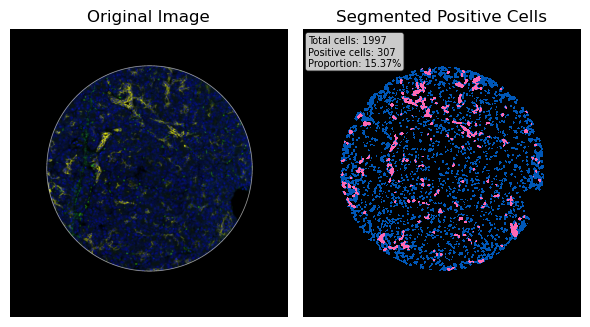

Processed p16.tiff


In [11]:
#write own function to visuzlied with input of image and masks
from matplotlib.colors import ListedColormap
import numpy as np

#load customzied mask of the corresponding ROI
customized_mask = np.load(customized_mask_path)

def mark_and_visualize_cells(image, masks, customized_mask):

    red_channel = image[:, :, 0]
    green_channel = image[:, :, 1]
    unique_cells = np.unique(masks)
    marked_mask = np.zeros_like(masks)

    pos_cells_count = 0
    total_cells_count = 0

    for cell_id in unique_cells:
        if cell_id == 0:  # skip the background
            continue

        total_cells_count += 1  # Count each cell
        cell_region = (masks == cell_id)

        # Calculate overlap with the customized mask
        overlap = np.sum(cell_region & (customized_mask > 0))
        cell_area = np.sum(cell_region)
        overlap_percentage = (overlap / cell_area) * 100 if cell_area > 0 else 0

        # Mark the cell based on overlap percentage
        if overlap_percentage > 10: #<<<<<<<<<<tune overalpping sensitivity 20% recommended
            marked_mask[cell_region] = 2  # Mark as positive
            pos_cells_count += 1
        else:
            marked_mask[cell_region] = 1  # Mark as negative

    # Create a color map where 0 is black, blue for non-positive, pink for positive
    max_value = np.max(marked_mask)
    if max_value == 1:  # Only non-positive cells are present
        custom_cmap = ListedColormap(['black', '#0057b7'])  # Background, Non-positive
    else:  # Both non-positive and positive cells are present
        custom_cmap = ListedColormap(['black', '#0057b7', '#ff69b4'])  # Background, Non-positive, Positive

    # Plot the original image and the marked mask
    fig, ax = plt.subplots(1, 2, figsize=(6, 4))

    # Original image
    ax[0].imshow(image)
    ax[0].axis('off')
    ax[0].set_title('Original Image')

    # Mask overlay on the original image
    ax[1].imshow(image)
    ax[1].imshow(marked_mask, cmap=custom_cmap, alpha=1)  # alpha for transparency
    ax[1].axis('off')
    ax[1].set_title('Segmented Positive Cells')

    # Adding text (cell counts)
    text_str = (
        f"Total cells: {total_cells_count}\n"
        f"Positive cells: {pos_cells_count}\n"
        f"Proportion: {pos_cells_count / total_cells_count:.2%}"
    )
    ax[1].text(0.02, 0.98, text_str, transform=ax[1].transAxes, fontsize=7,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    #plt.savefig(f"{output_dir}{sid}.seg.pdf", format="pdf")
    plt.show()

mark_and_visualize_cells(image, masks, customized_mask)

print(f"Processed {sid}")
